# Adaptive Filters in Biomedical Signal Processing
## Interactive Demonstration Notebook
### Fardin Afdideh

This notebook demonstrates different adaptive filter algorithms and compares their:
- Convergence rates
- Steady-state error
- Computational complexity
- Performance on biomedical signals

## Section 1: Setup and Installation

In [1]:
# Install required packages
!pip install numpy matplotlib scipy -q

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

print("All packages installed successfully!")

All packages installed successfully!


## Section 2: Generate Synthetic Biomedical Signals

We'll generate a realistic ECG signal with proper **PQRST complex** morphology:

- **P wave**: Atrial depolarization (~90ms duration, 0.15mV amplitude)
- **Q wave**: Initial ventricular depolarization (~20ms duration, -0.15mV amplitude)
- **R wave**: Main ventricular depolarization (~30ms duration, 1.2mV amplitude)
- **S wave**: Final ventricular depolarization (~40ms duration, -0.25mV amplitude)  
- **T wave**: Ventricular repolarization (~160ms duration, 0.3mV amplitude)

The signal is generated at 360 Hz (typical for biomedical applications) with physiologically accurate timing intervals.

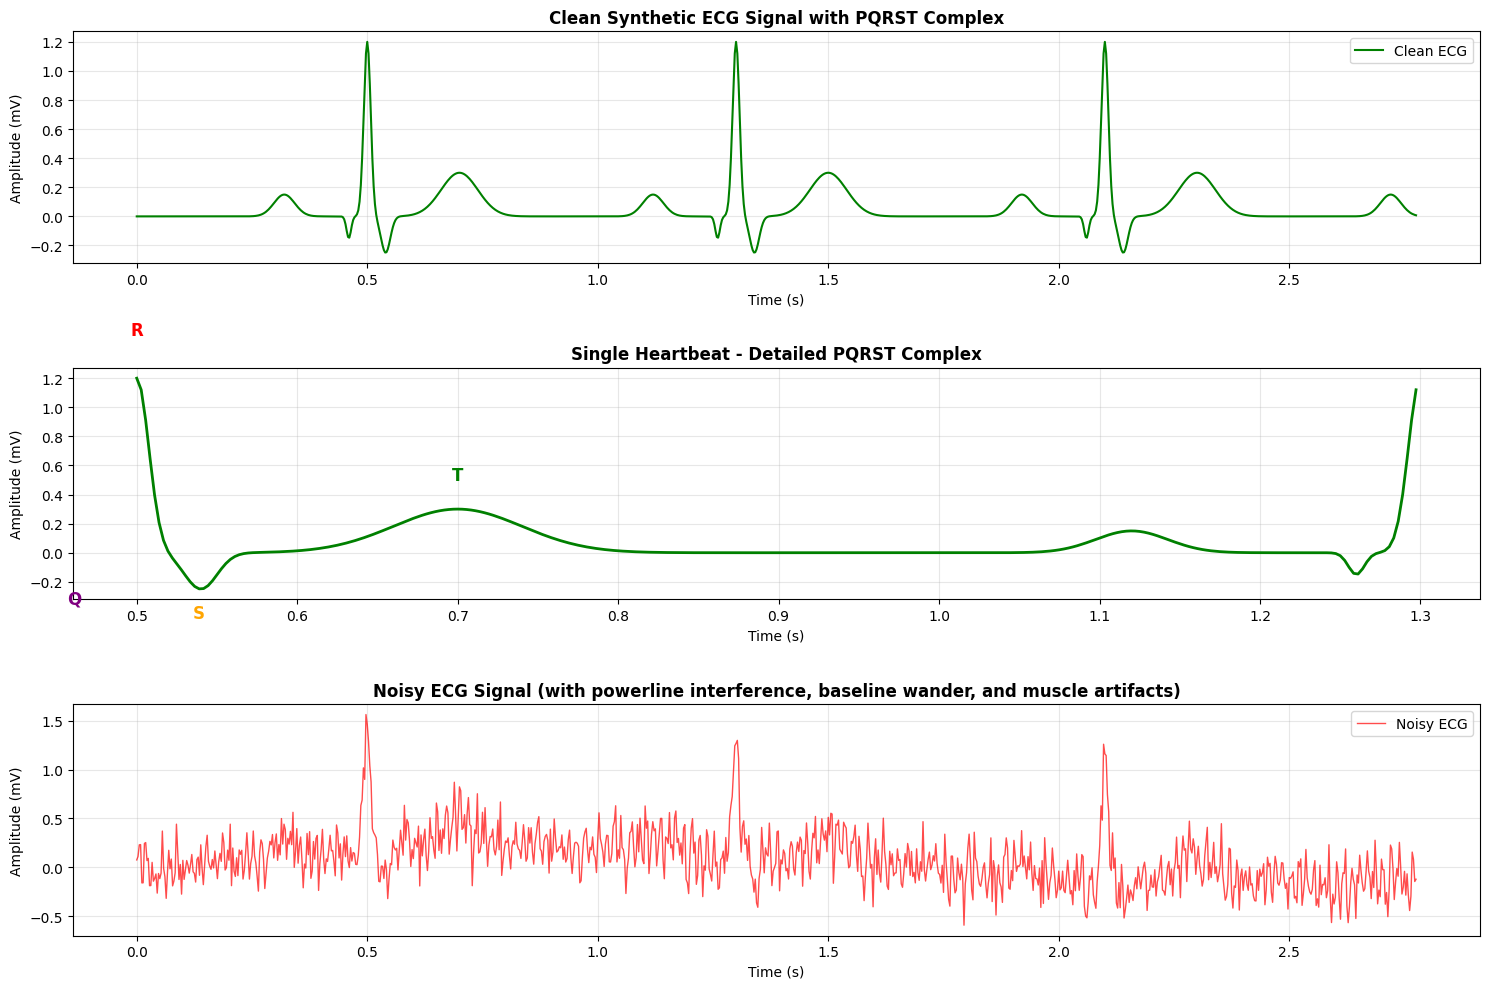

Generated realistic ECG signal with PQRST complex:
  - Duration: 10s
  - Sampling frequency: 360 Hz
  - Heart rate: 75 bpm
  - Total samples: 3600
  - RR interval: 0.800 s


In [2]:
def generate_ecg_pqrst(duration=10, fs=360, heart_rate=75):
    """
    Generate realistic synthetic ECG signal with proper PQRST complex

    Parameters:
    -----------
    duration : float
        Signal duration in seconds
    fs : int
        Sampling frequency in Hz
    heart_rate : int
        Heart rate in beats per minute (bpm)

    Returns:
    --------
    t : ndarray
        Time vector
    ecg : ndarray
        Synthetic ECG signal with realistic PQRST morphology
    """
    t = np.arange(0, duration, 1/fs)
    ecg = np.zeros_like(t)

    # Calculate RR interval
    rr_interval = 60.0 / heart_rate  # seconds between beats

    # Physiologically realistic PQRST parameters (in seconds relative to R-peak)
    # Based on typical ECG intervals at 75 bpm
    pqrst_params = {
        'P': {
            'time_offset': -0.18,      # P wave occurs ~180ms before R
            'amplitude': 0.15,          # P wave amplitude (mV)
            'duration': 0.09,           # P wave duration ~90ms
        },
        'Q': {
            'time_offset': -0.04,       # Q wave occurs ~40ms before R
            'amplitude': -0.15,         # Q wave amplitude (negative)
            'duration': 0.02,           # Q wave duration ~20ms
        },
        'R': {
            'time_offset': 0.0,         # R peak at reference time
            'amplitude': 1.2,           # R wave amplitude (mV)
            'duration': 0.03,           # R wave duration ~30ms
        },
        'S': {
            'time_offset': 0.04,        # S wave occurs ~40ms after R
            'amplitude': -0.25,         # S wave amplitude (negative)
            'duration': 0.04,           # S wave duration ~40ms
        },
        'T': {
            'time_offset': 0.20,        # T wave occurs ~200ms after R
            'amplitude': 0.3,           # T wave amplitude (mV)
            'duration': 0.16,           # T wave duration ~160ms
        }
    }

    # Generate each heartbeat
    num_beats = int(duration / rr_interval)

    for beat_idx in range(num_beats):
        beat_time = beat_idx * rr_interval + 0.5  # Start with offset to avoid edge effects

        if beat_time + 0.3 > duration:  # Avoid incomplete beats at end
            break

        # Generate each component of PQRST complex
        for wave_name, params in pqrst_params.items():
            peak_time = beat_time + params['time_offset']
            amplitude = params['amplitude']
            sigma = params['duration'] / 4  # Gaussian width from duration

            # Gaussian function for each wave
            wave = amplitude * np.exp(-((t - peak_time) ** 2) / (2 * sigma ** 2))
            ecg += wave

    # Add slight baseline offset and normalize
    ecg = ecg - np.mean(ecg[:int(0.2*fs)])  # Remove DC offset using first 200ms

    return t, ecg

def add_noise_artifacts(signal, noise_level=0.1, powerline=True, baseline_wander=True):
    """Add various noise artifacts to simulate real biomedical signals"""
    noisy_signal = signal.copy()
    t = np.linspace(0, len(signal)/360, len(signal))

    # White noise (muscle artifacts)
    noisy_signal += noise_level * np.random.randn(len(signal))

    # Powerline interference (50/60 Hz)
    if powerline:
        noisy_signal += 0.15 * np.sin(2 * np.pi * 60 * t)

    # Baseline wander (breathing, movement)
    if baseline_wander:
        noisy_signal += 0.2 * np.sin(2 * np.pi * 0.3 * t)

    return noisy_signal

# Generate signals with realistic PQRST morphology
np.random.seed(42)  # For reproducibility
duration = 10  # seconds
fs = 360  # Hz
heart_rate = 75  # bpm

t, clean_ecg = generate_ecg_pqrst(duration=duration, fs=fs, heart_rate=heart_rate)
noisy_ecg = add_noise_artifacts(clean_ecg, noise_level=0.15)

# Visualization
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Plot 1: Full signal overview
axes[0].plot(t[:1000], clean_ecg[:1000], 'g-', linewidth=1.5, label='Clean ECG')
axes[0].set_title('Clean Synthetic ECG Signal with PQRST Complex', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude (mV)')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: Zoomed view of single heartbeat to show PQRST detail
beat_start = int(0.5 * fs)  # Start at 0.5s
beat_end = beat_start + int(0.8 * fs)  # Show one complete beat
axes[1].plot(t[beat_start:beat_end], clean_ecg[beat_start:beat_end], 'g-', linewidth=2)
axes[1].set_title('Single Heartbeat - Detailed PQRST Complex', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude (mV)')
axes[1].grid(True, alpha=0.3)

# Annotate PQRST waves
peak_idx = beat_start + np.argmax(clean_ecg[beat_start:beat_end])
axes[1].annotate('R', xy=(t[peak_idx], clean_ecg[peak_idx]),
                xytext=(t[peak_idx], clean_ecg[peak_idx] + 0.3),
                ha='center', fontsize=12, fontweight='bold', color='red')
axes[1].annotate('P', xy=(t[peak_idx - int(0.18*fs)], clean_ecg[peak_idx - int(0.18*fs)]),
                xytext=(t[peak_idx - int(0.18*fs)], clean_ecg[peak_idx - int(0.18*fs)] + 0.2),
                ha='center', fontsize=12, fontweight='bold', color='blue')
axes[1].annotate('Q', xy=(t[peak_idx - int(0.04*fs)], clean_ecg[peak_idx - int(0.04*fs)]),
                xytext=(t[peak_idx - int(0.04*fs)], clean_ecg[peak_idx - int(0.04*fs)] - 0.2),
                ha='center', fontsize=12, fontweight='bold', color='purple')
axes[1].annotate('S', xy=(t[peak_idx + int(0.04*fs)], clean_ecg[peak_idx + int(0.04*fs)]),
                xytext=(t[peak_idx + int(0.04*fs)], clean_ecg[peak_idx + int(0.04*fs)] - 0.2),
                ha='center', fontsize=12, fontweight='bold', color='orange')
axes[1].annotate('T', xy=(t[peak_idx + int(0.20*fs)], clean_ecg[peak_idx + int(0.20*fs)]),
                xytext=(t[peak_idx + int(0.20*fs)], clean_ecg[peak_idx + int(0.20*fs)] + 0.2),
                ha='center', fontsize=12, fontweight='bold', color='green')

# Plot 3: Noisy signal
axes[2].plot(t[:1000], noisy_ecg[:1000], 'r-', linewidth=1, alpha=0.7, label='Noisy ECG')
axes[2].set_title('Noisy ECG Signal (with powerline interference, baseline wander, and muscle artifacts)',
                 fontsize=12, fontweight='bold')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Amplitude (mV)')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"Generated realistic ECG signal with PQRST complex:")
print(f"  - Duration: {duration}s")
print(f"  - Sampling frequency: {fs} Hz")
print(f"  - Heart rate: {heart_rate} bpm")
print(f"  - Total samples: {len(clean_ecg)}")
print(f"  - RR interval: {60/heart_rate:.3f} s")

## Section 3: Implement Adaptive Filter Algorithms

We'll implement three popular adaptive filtering algorithms:
- **LMS (Least Mean Squares)**: Simple and computationally efficient
- **NLMS (Normalized LMS)**: Improved convergence with normalization
- **RLS (Recursive Least Squares)**: Fastest convergence but higher complexity

In [3]:
class LMSFilter:
    """Least Mean Squares (LMS) Adaptive Filter"""
    def __init__(self, n_taps, mu=0.01):
        self.n_taps = n_taps
        self.mu = mu  # Step size
        self.w = np.zeros(n_taps)  # Filter coefficients
        self.mse_history = []

    def filter(self, x, d):
        """
        x: input signal (reference/correlated noise)
        d: desired signal (noisy signal to be cleaned)
        """
        N = len(x)
        y = np.zeros(N)
        e = np.zeros(N)

        for n in range(self.n_taps, N):
            x_n = x[n:n-self.n_taps:-1]  # Current input vector
            y[n] = np.dot(self.w, x_n)    # Filter output (estimated noise)
            e[n] = d[n] - y[n]            # Error (cleaned signal)
            self.w += 2 * self.mu * e[n] * x_n  # LMS update
            self.mse_history.append(e[n]**2)

        return y, e

class NLMSFilter:
    """Normalized Least Mean Squares (NLMS) Adaptive Filter"""
    def __init__(self, n_taps, mu=0.5, epsilon=1e-6):
        self.n_taps = n_taps
        self.mu = mu
        self.epsilon = epsilon
        self.w = np.zeros(n_taps)
        self.mse_history = []

    def filter(self, x, d):
        N = len(x)
        y = np.zeros(N)
        e = np.zeros(N)

        for n in range(self.n_taps, N):
            x_n = x[n:n-self.n_taps:-1]
            y[n] = np.dot(self.w, x_n)
            e[n] = d[n] - y[n]
            # Normalized step size
            norm_factor = self.epsilon + np.dot(x_n, x_n)
            self.w += (self.mu / norm_factor) * e[n] * x_n
            self.mse_history.append(e[n]**2)

        return y, e

class RLSFilter:
    """Recursive Least Squares (RLS) Adaptive Filter"""
    def __init__(self, n_taps, lambda_factor=0.99, delta=1.0):
        self.n_taps = n_taps
        self.lambda_factor = lambda_factor  # Forgetting factor
        self.w = np.zeros(n_taps)
        self.P = delta * np.eye(n_taps)  # Inverse correlation matrix
        self.mse_history = []

    def filter(self, x, d):
        N = len(x)
        y = np.zeros(N)
        e = np.zeros(N)

        for n in range(self.n_taps, N):
            x_n = x[n:n-self.n_taps:-1].reshape(-1, 1)
            y[n] = np.dot(self.w, x_n.flatten())
            e[n] = d[n] - y[n]

            # RLS update equations
            pi = np.dot(self.P, x_n)
            k = pi / (self.lambda_factor + np.dot(x_n.T, pi))
            self.P = (self.P - np.dot(k, pi.T)) / self.lambda_factor
            self.w += (k * e[n]).flatten()

            self.mse_history.append(e[n]**2)

        return y, e

print("Adaptive filter classes implemented!")
print("  - LMS: Simple, computationally efficient")
print("  - NLMS: Improved convergence with normalization")
print("  - RLS: Fastest convergence, higher complexity")

Adaptive filter classes implemented!
  - LMS: Simple, computationally efficient
  - NLMS: Improved convergence with normalization
  - RLS: Fastest convergence, higher complexity


## Section 4: Compare Algorithm Performance

Now we'll create a reference noise signal that's correlated with the noise in our ECG and use it to adaptively filter the noisy signal.

In [4]:
# Create reference noise signal (correlated with noise in ECG)
# This simulates having a separate sensor that captures primarily noise
np.random.seed(42)
reference_noise = 0.15 * np.sin(2 * np.pi * 60 * t) + 0.2 * np.sin(2 * np.pi * 0.3 * t) + 0.1 * np.random.randn(len(t))

# Initialize filters
n_taps = 32
lms = LMSFilter(n_taps=n_taps, mu=0.01)
nlms = NLMSFilter(n_taps=n_taps, mu=0.5)
rls = RLSFilter(n_taps=n_taps, lambda_factor=0.995)

print(f"Testing with {n_taps} filter taps...")

# Apply filters
# x = reference noise (input)
# d = noisy ECG (desired)
# e = filtered output (cleaned signal)
y_lms, e_lms = lms.filter(reference_noise, noisy_ecg)
y_nlms, e_nlms = nlms.filter(reference_noise, noisy_ecg)
y_rls, e_rls = rls.filter(reference_noise, noisy_ecg)

# Calculate performance metrics
def calculate_snr(clean, noisy):
    """Calculate Signal-to-Noise Ratio in dB"""
    signal_power = np.mean(clean ** 2)
    noise_power = np.mean((clean - noisy) ** 2)
    if noise_power < 1e-10:
        return float('inf')
    return 10 * np.log10(signal_power / noise_power)

snr_original = calculate_snr(clean_ecg, noisy_ecg)
snr_lms = calculate_snr(clean_ecg, e_lms)
snr_nlms = calculate_snr(clean_ecg, e_nlms)
snr_rls = calculate_snr(clean_ecg, e_rls)

print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print(f"Original SNR:      {snr_original:6.2f} dB")
print(f"LMS SNR:           {snr_lms:6.2f} dB  (Improvement: {snr_lms-snr_original:+.2f} dB)")
print(f"NLMS SNR:          {snr_nlms:6.2f} dB  (Improvement: {snr_nlms-snr_original:+.2f} dB)")
print(f"RLS SNR:           {snr_rls:6.2f} dB  (Improvement: {snr_rls-snr_original:+.2f} dB)")
print("="*60)

Testing with 32 filter taps...

PERFORMANCE COMPARISON
Original SNR:       -2.11 dB
LMS SNR:             3.53 dB  (Improvement: +5.64 dB)
NLMS SNR:            1.12 dB  (Improvement: +3.23 dB)
RLS SNR:             9.13 dB  (Improvement: +11.24 dB)


## Section 5: Visualize Filtered Signals

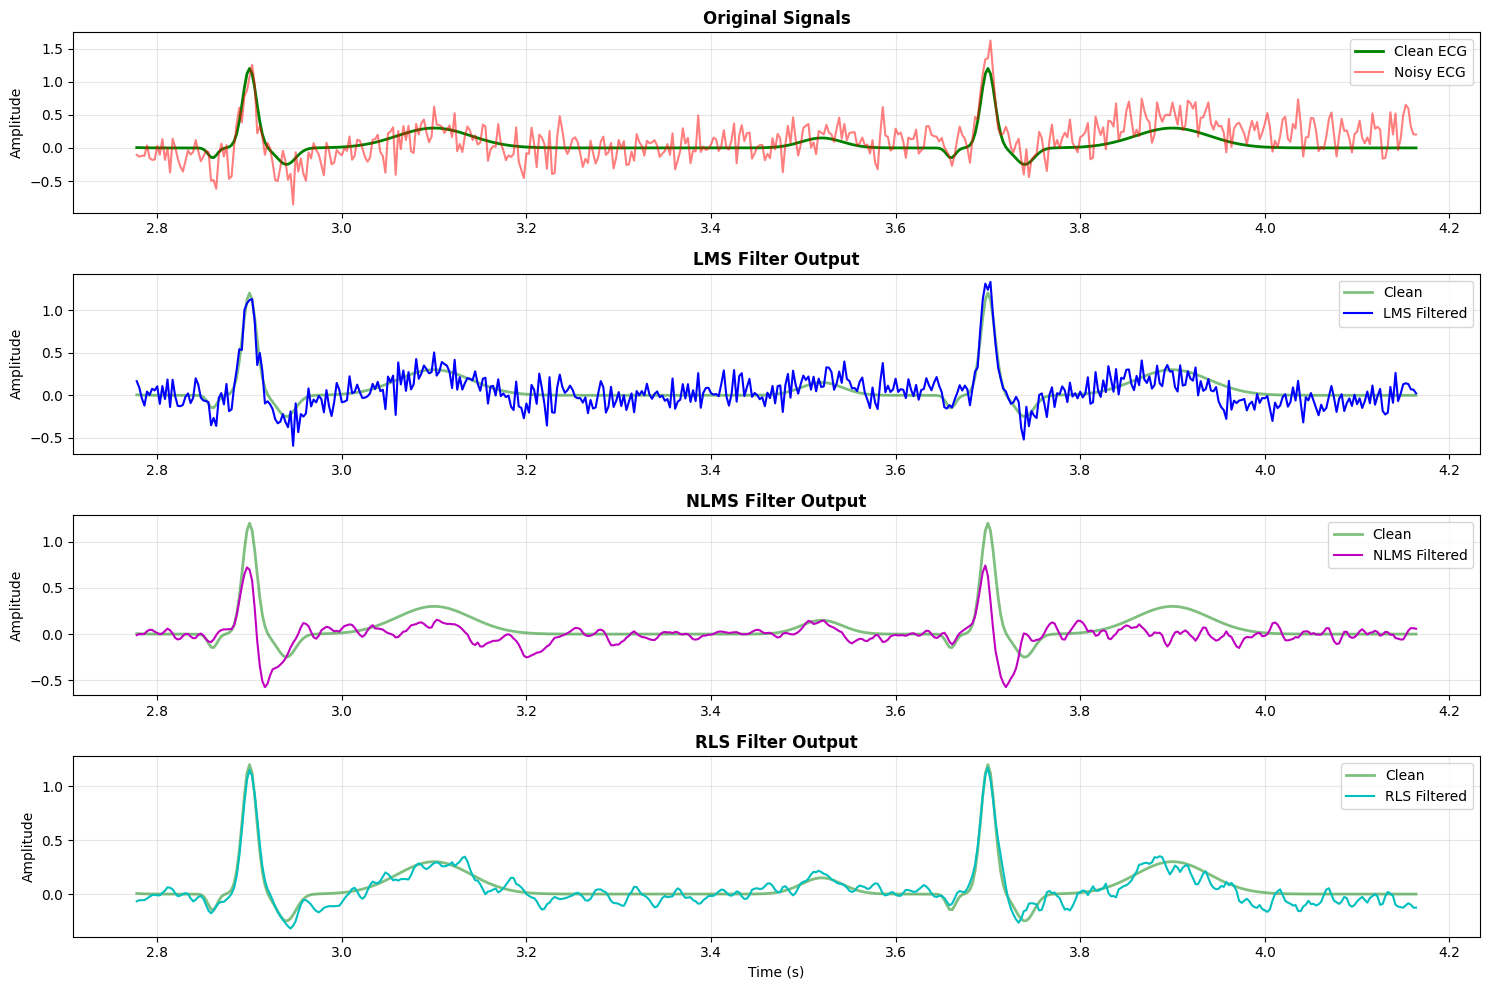

In [5]:
plt.figure(figsize=(15, 10))

# Plot filtered signals
sample_range = slice(1000, 1500)

plt.subplot(4, 1, 1)
plt.plot(t[sample_range], clean_ecg[sample_range], 'g-', linewidth=2, label='Clean ECG')
plt.plot(t[sample_range], noisy_ecg[sample_range], 'r-', alpha=0.5, label='Noisy ECG')
plt.title('Original Signals', fontsize=12, fontweight='bold')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 2)
plt.plot(t[sample_range], clean_ecg[sample_range], 'g-', linewidth=2, alpha=0.5, label='Clean')
plt.plot(t[sample_range], e_lms[sample_range], 'b-', linewidth=1.5, label='LMS Filtered')
plt.title('LMS Filter Output', fontsize=12, fontweight='bold')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 3)
plt.plot(t[sample_range], clean_ecg[sample_range], 'g-', linewidth=2, alpha=0.5, label='Clean')
plt.plot(t[sample_range], e_nlms[sample_range], 'm-', linewidth=1.5, label='NLMS Filtered')
plt.title('NLMS Filter Output', fontsize=12, fontweight='bold')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.subplot(4, 1, 4)
plt.plot(t[sample_range], clean_ecg[sample_range], 'g-', linewidth=2, alpha=0.5, label='Clean')
plt.plot(t[sample_range], e_rls[sample_range], 'c-', linewidth=1.5, label='RLS Filtered')
plt.title('RLS Filter Output', fontsize=12, fontweight='bold')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Section 6: Convergence Rate Comparison

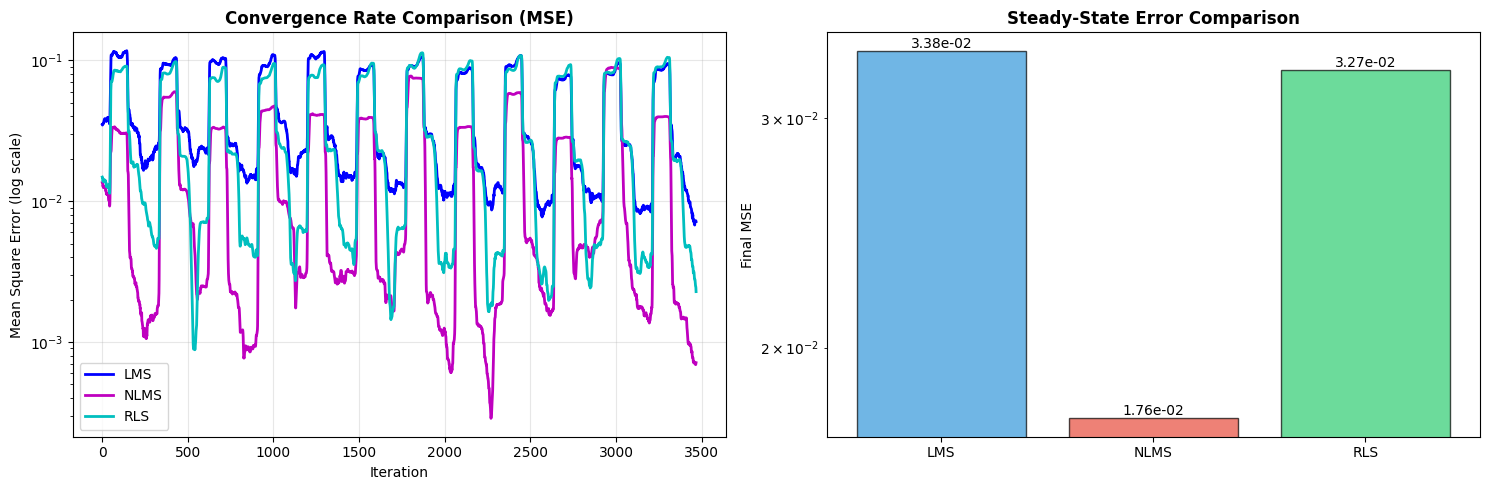

In [6]:
plt.figure(figsize=(15, 5))

# Plot MSE convergence
window = 100  # Smoothing window

def smooth(x, window):
    return np.convolve(x, np.ones(window)/window, mode='valid')

plt.subplot(1, 2, 1)
plt.semilogy(smooth(lms.mse_history, window), 'b-', linewidth=2, label='LMS')
plt.semilogy(smooth(nlms.mse_history, window), 'm-', linewidth=2, label='NLMS')
plt.semilogy(smooth(rls.mse_history, window), 'c-', linewidth=2, label='RLS')
plt.title('Convergence Rate Comparison (MSE)', fontsize=12, fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('Mean Square Error (log scale)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot final MSE comparison
plt.subplot(1, 2, 2)
final_mse = [
    np.mean(lms.mse_history[-1000:]),
    np.mean(nlms.mse_history[-1000:]),
    np.mean(rls.mse_history[-1000:])
]
algorithms = ['LMS', 'NLMS', 'RLS']
colors = ['#3498db', '#e74c3c', '#2ecc71']
bars = plt.bar(algorithms, final_mse, color=colors, alpha=0.7, edgecolor='black')
plt.title('Steady-State Error Comparison', fontsize=12, fontweight='bold')
plt.ylabel('Final MSE')
plt.yscale('log')
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, final_mse):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2e}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## Section 7: Algorithm Characteristics Summary

In [7]:
import pandas as pd

summary_data = {
    'Algorithm': ['LMS', 'NLMS', 'RLS'],
    'Convergence Speed': ['Slow', 'Medium', 'Fast'],
    'Computational Complexity': ['Low (O(N))', 'Low (O(N))', 'High (O(N²))'],
    'Stability': ['Good with proper μ', 'Better than LMS', 'Excellent'],
    'Best Use Case': [
        'Real-time, low power',
        'Non-stationary signals',
        'High accuracy needed'
    ]
}

df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("ALGORITHM CHARACTERISTICS SUMMARY")
print("="*80)
print(df.to_string(index=False))
print("="*80)


ALGORITHM CHARACTERISTICS SUMMARY
Algorithm Convergence Speed Computational Complexity          Stability          Best Use Case
      LMS              Slow               Low (O(N)) Good with proper μ   Real-time, low power
     NLMS            Medium               Low (O(N))    Better than LMS Non-stationary signals
      RLS              Fast             High (O(N²))          Excellent   High accuracy needed


## Section 8: Interactive Parameter Exploration

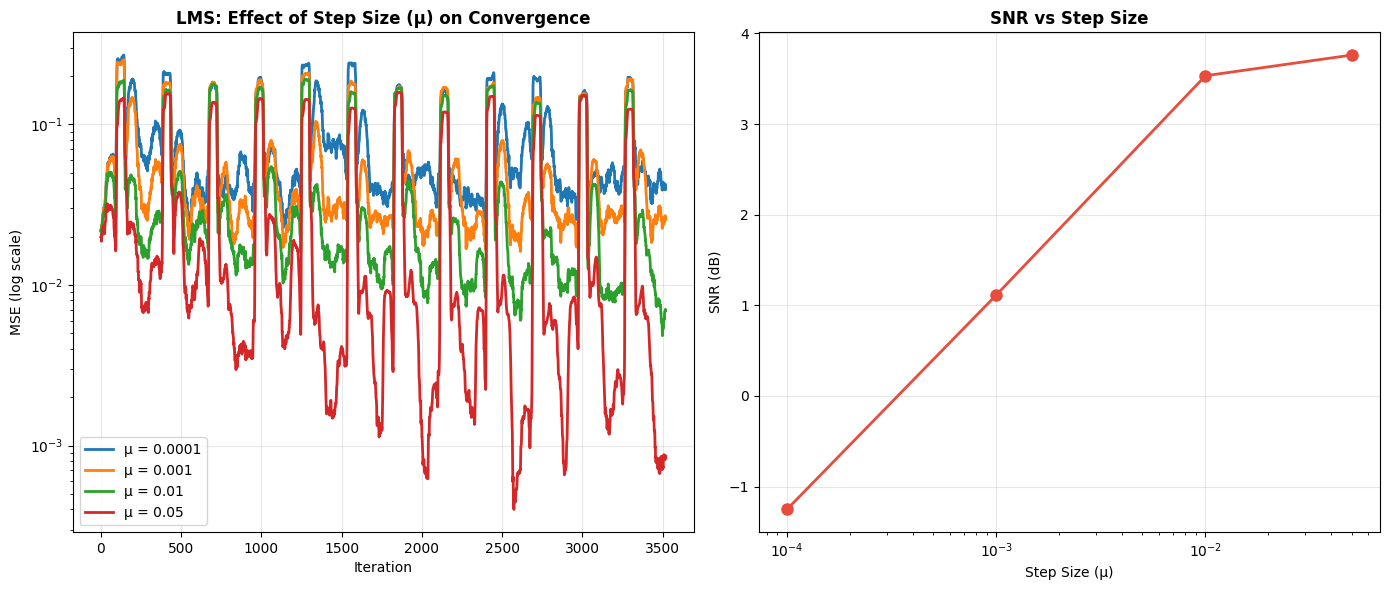


Optimal step size balances convergence speed and stability
Best SNR achieved: 3.76 dB at μ = 0.05


In [8]:
def test_step_size_effect(mu_values=[0.0001, 0.001, 0.01, 0.05]):
    """Test effect of step size on LMS convergence"""
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    for mu in mu_values:
        lms_test = LMSFilter(n_taps=32, mu=mu)
        y_test, e_test = lms_test.filter(reference_noise, noisy_ecg)
        plt.semilogy(smooth(lms_test.mse_history, 50), linewidth=2, label=f'μ = {mu}')

    plt.title('LMS: Effect of Step Size (μ) on Convergence', fontsize=12, fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('MSE (log scale)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    snr_values = []
    for mu in mu_values:
        lms_test = LMSFilter(n_taps=32, mu=mu)
        y_test, e_test = lms_test.filter(reference_noise, noisy_ecg)
        snr = calculate_snr(clean_ecg, e_test)
        snr_values.append(snr)

    plt.plot(mu_values, snr_values, 'o-', linewidth=2, markersize=8, color='#e74c3c')
    plt.title('SNR vs Step Size', fontsize=12, fontweight='bold')
    plt.xlabel('Step Size (μ)')
    plt.ylabel('SNR (dB)')
    plt.xscale('log')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nOptimal step size balances convergence speed and stability")
    print(f"Best SNR achieved: {max(snr_values):.2f} dB at μ = {mu_values[snr_values.index(max(snr_values))]}")

test_step_size_effect()

## Section 9: Real Biomedical Application Examples

In [9]:
print("\n" + "="*80)
print("BIOMEDICAL APPLICATIONS")
print("="*80)

applications = {
    "ECG Enhancement": [
        "- Remove powerline interference (50/60 Hz)",
        "- Reduce muscle artifacts",
        "- Eliminate baseline wander",
        "- Enable accurate heart disease diagnosis"
    ],
    "EEG Processing": [
        "- Remove eye blink artifacts",
        "- Reduce cardiac interference",
        "- Filter muscle/movement artifacts",
        "- Improve brain-computer interface (BCI) accuracy"
    ],
    "EMG Analysis": [
        "- Remove ECG interference from EMG",
        "- Reduce motion artifacts",
        "- Aid in movement disorder diagnosis"
    ],
    "Other Applications": [
        "- Hearing aid feedback cancellation",
        "- PPG motion artifact removal",
        "- Fetal ECG extraction",
        "- Respiratory signal enhancement"
    ]
}

for app, details in applications.items():
    print(f"\n{app}:")
    for detail in details:
        print(f"  {detail}")

print("\n" + "="*80)


BIOMEDICAL APPLICATIONS

ECG Enhancement:
  - Remove powerline interference (50/60 Hz)
  - Reduce muscle artifacts
  - Eliminate baseline wander
  - Enable accurate heart disease diagnosis

EEG Processing:
  - Remove eye blink artifacts
  - Reduce cardiac interference
  - Filter muscle/movement artifacts
  - Improve brain-computer interface (BCI) accuracy

EMG Analysis:
  - Remove ECG interference from EMG
  - Reduce motion artifacts
  - Aid in movement disorder diagnosis

Other Applications:
  - Hearing aid feedback cancellation
  - PPG motion artifact removal
  - Fetal ECG extraction
  - Respiratory signal enhancement



## Section 10: Key Takeaways and Recommendations

In [10]:
print("\n" + "="*80)
print("KEY TAKEAWAYS")
print("="*80)
print("""
1. ALGORITHM SELECTION:
   → LMS: Best for real-time, resource-constrained applications
   → NLMS: Good balance between performance and complexity
   → RLS: Use when fastest convergence and best accuracy are critical

2. CONVERGENCE FACTORS:
   → Step size (μ) critically affects stability and speed
   → Filter length (taps) impacts adaptation capability
   → Signal characteristics influence algorithm choice

3. BIOMEDICAL CONSIDERATIONS:
   → Must preserve physiological information
   → Real-time processing often required
   → Energy efficiency crucial for wearables
   → Robustness to non-stationary signals essential

4. FUTURE DIRECTIONS:
   → Integration with machine learning
   → Adaptive hybrid algorithms
   → Energy-efficient implementations for IoT devices
   → Advanced nonlinear adaptive filtering
""")
print("="*80)

print("\nDemonstration Complete!")
print("\nExperiment with different parameters:")
print("  - Change n_taps (filter length)")
print("  - Modify mu (step size)")
print("  - Adjust noise levels")
print("  - Try different signal types")


KEY TAKEAWAYS

1. ALGORITHM SELECTION:
   → LMS: Best for real-time, resource-constrained applications
   → NLMS: Good balance between performance and complexity
   → RLS: Use when fastest convergence and best accuracy are critical

2. CONVERGENCE FACTORS:
   → Step size (μ) critically affects stability and speed
   → Filter length (taps) impacts adaptation capability
   → Signal characteristics influence algorithm choice

3. BIOMEDICAL CONSIDERATIONS:
   → Must preserve physiological information
   → Real-time processing often required
   → Energy efficiency crucial for wearables
   → Robustness to non-stationary signals essential

4. FUTURE DIRECTIONS:
   → Integration with machine learning
   → Adaptive hybrid algorithms
   → Energy-efficient implementations for IoT devices
   → Advanced nonlinear adaptive filtering


Demonstration Complete!

Experiment with different parameters:
  - Change n_taps (filter length)
  - Modify mu (step size)
  - Adjust noise levels
  - Try different s